<a href="https://colab.research.google.com/github/arnav-pati/Meta-Learning-to-improve-EEG-Motor-Imagery-Classification/blob/main/bciiv2a_Reptile_EEGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd gdrive/MyDrive/EEGdatasets

/content/gdrive/MyDrive/EEGdatasets


In [3]:
%pwd

'/content/gdrive/MyDrive/EEGdatasets'

# Setup

In [4]:
! pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 11.4 MB/s eta 0:00:00


In [5]:
import torch
from torch import nn, optim, autograd
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.nn import functional as F
import numpy as np
np.random.seed(42)
torch.manual_seed(42)
from torch.utils.data import Dataset, DataLoader
from tensorboardX import SummaryWriter
from tqdm import tqdm
import os
import os.path
import errno

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [7]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

# Dataset

In [8]:
class DataNShot():
	def __init__(self, root, data_npy, train_subj, test_subj, batchsz, n_way, k_shot, k_query, eeg_shape, num_trials, batchst=1):
		self.num_trials = num_trials
		self.batchsz = {"train": batchsz, "test": batchst}
		self.n_way = n_way
		self.k_shot = k_shot
		self.k_query = k_query
		self.eeg_shape = eeg_shape
		self.root = root
		self.data_npy = data_npy
		self.train_subj = train_subj
		self.test_subj = test_subj
		self.subj = {"train": self.train_subj, "test": self.test_subj}

	def get_data(self, mode, subj, cls, trial):
		return np.load(os.path.join(self.root, self.data_npy+'_'+mode, f"s{subj}_c{cls}_t{trial}.npy"))

	def get_batch(self, mode):
		setsz = self.k_shot * self.n_way
		querysz = self.k_query * self.n_way
		num_subj = self.subj[mode]

		support_x = np.zeros((self.batchsz[mode], setsz) + self.eeg_shape)
		support_y = np.zeros((self.batchsz[mode], setsz), dtype=int)
		query_x = np.zeros((self.batchsz[mode], querysz) + self.eeg_shape)
		query_y = np.zeros((self.batchsz[mode], querysz), dtype=int)

		selected_tasks = np.random.choice(num_subj, self.batchsz[mode], False)
		for i, cur_task in enumerate(selected_tasks):
			shuffle_idx = np.arange(self.n_way)
			np.random.shuffle(shuffle_idx)
			shuffle_idx_test = np.arange(self.n_way)
			np.random.shuffle(shuffle_idx_test)

			for j in range(self.n_way):
				selected_data = np.random.choice(self.num_trials, self.k_shot + self.k_query, False)

				for offset, eeg in enumerate(selected_data[:self.k_shot]):
					support_x[i, shuffle_idx[j] * self.k_shot + offset, ...] = self.get_data(mode, cur_task, j, eeg)
					support_y[i, shuffle_idx[j] * self.k_shot + offset] = j

				for offset, eeg in enumerate(selected_data[self.k_shot:]):
						query_x[i, shuffle_idx_test[j] * self.k_query + offset, ...] = self.get_data(mode, cur_task, j, eeg)
						query_y[i, shuffle_idx_test[j] * self.k_query + offset] = j
	
		return support_x, support_y, query_x, query_y

In [9]:
class CustomDataset(Dataset):
    def __init__(self, db, mode, k_shot, k_query) -> None:
        super().__init__()
        # self.data = data
        self.db = db
        self.mode = mode
        self.shape = (len(db.subj[mode]), db.n_way, db.num_trials) + db.eeg_shape
        self.n_way = self.shape[1]
        self.k_shot = k_shot
        self.k_query = k_query
        self.out_shape = (self.n_way * self.k_shot,) + self.shape[-2:]
        self.out_shape_query = (self.n_way * self.k_query,) + self.shape[-2:]
        self.shuffle_idx = np.zeros(self.shape[:3], dtype=int)
        for p in range(self.shape[0]):
            for q in range(self.shape[1]):
                idx_range = np.arange(self.shape[2])
                np.random.shuffle(idx_range)
                self.shuffle_idx[p, q, ...] = idx_range
    
    def __len__(self):
        return self.shape[0] * (self.shape[2] // (self.k_shot + self.k_query))
    
    def __getitem__(self, idx):
        idx2 = (self.k_shot + self.k_query) * (idx // self.shape[0])
        idx0 = idx % self.shape[0]

        support_x = np.zeros(self.out_shape)
        support_y = np.zeros(self.out_shape[:1], dtype=int)
        query_x = np.zeros(self.out_shape_query)
        query_y = np.zeros(self.out_shape_query[:1], dtype=int)
        
        for j in range(self.n_way):
            # support_x[(j*self.k_shot):((j+1)*self.k_shot), ...] = self.data[idx0][j][self.shuffle_idx[idx0, j, idx2:idx2+self.k_shot]]
            for v in range(self.k_shot):
                support_x[(j*self.k_shot) + v, ...] = self.db.get_data(self.mode, self.db.subj[self.mode][idx0], j, self.shuffle_idx[idx0, j, idx2+v])
            support_y[(j*self.k_shot):((j+1)*self.k_shot)] = j

            # query_x[(j*self.k_query):((j+1)*self.k_query), ...] = self.data[idx0][j][self.shuffle_idx[idx0, j, idx2+self.k_shot:idx2+self.k_shot+self.k_query]]
            for v in range(self.k_query):
                query_x[(j*self.k_query) + v, ...] = self.db.get_data(self.mode, self.db.subj[self.mode][idx0], j, self.shuffle_idx[idx0, j, idx2+self.k_shot+v])
            query_y[(j*self.k_query):((j+1)*self.k_query)] = j
        
        return support_x, support_y, query_x, query_y

# Reptile

In [10]:
class Learner(nn.Module):
    '''
    It stores a specific nn.Module class
    '''

    def __init__(self, net_class, *args) -> None:
        '''
        net_class is a class, not an instance
        args: the parameters for net_class
        '''
        super(Learner, self).__init__()
        assert net_class.__class__ == type

        self.net = net_class(*args).to(DEVICE)
        self.net_pi = net_class(*args).to(DEVICE)
        self.learner_lr = 0.1
        self.optimizer = optim.SGD(self.net_pi.parameters(), self.learner_lr)
    
    def parameters(self):
        '''
        ignore self.net_pi.parameters()
        '''
        return self.net.parameters()
    
    def update_pi(self):
        for m_from, m_to in zip(self.net.modules(), self.net_pi.modules()):
            if isinstance(m_to, nn.Linear) or isinstance(m_to, nn.Conv2d) or isinstance(m_to, nn.BatchNorm2d):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()
    
    def forward(self, support_x, support_y, query_x, query_y, num_updates, testing=False):
        self.update_pi()
        if testing:
            self.net_pi.freeze()
        for i in range(num_updates):
            loss, pred = self.net_pi(support_x, support_y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if testing:
            self.net_pi.unfreeze()
        loss, pred = self.net_pi(query_x, query_y)
        indices = torch.argmax(pred, dim=1)
        correct = torch.eq(indices, query_y).sum().item()
        acc = correct / query_y.size(0)
        
        grads_pi = autograd.grad(loss, self.net_pi.parameters(), create_graph=True)
        return loss, grads_pi, acc
    
    def net_forward(self, support_x, support_y):
        loss, pred = self.net(support_x, support_y)
        return loss, pred

In [11]:
class MetaLearner(nn.Module):
    def __init__(self, net_class, net_class_args, n_way, k_shot, meta_batchesz, beta, num_updates, num_updates_test) -> None:
        super(MetaLearner, self).__init__()
        self.n_way = n_way
        self.k_shot = k_shot
        self.meta_batchesz = meta_batchesz
        self.beta = beta
        self.num_updates = num_updates
        self.num_updates_test = num_updates_test

        self.learner = Learner(net_class, *net_class_args)
        self.optimizer = optim.Adam(self.learner.parameters(), lr=beta)
    
    def write_grads(self, dummy_loss, sum_grads_pi):
        hooks = []
        for i, v in enumerate(self.learner.parameters()):
            def closure():
                ii = i
                return lambda grad : sum_grads_pi[ii]
            # h = v.register_hook(closure())
            hooks.append(v.register_hook(closure()))
        
        self.optimizer.zero_grad()
        dummy_loss.backward()
        self.optimizer.step()

        for h in hooks:
            h.remove()
    
    def forward(self, support_x, support_y, query_x, query_y):
        sum_grads_pi = None
        meta_batchesz = support_y.size(0)

        accs = []
        for i in range(meta_batchesz):
            _, grad_pi, episode_acc = self.learner(support_x[i], support_y[i], query_x[i], query_y[i], self.num_updates)
            accs.append(episode_acc)
            if sum_grads_pi is None:
                sum_grads_pi = grad_pi
            else:
                sum_grads_pi = [torch.add(p, q) for p, q in zip(sum_grads_pi, grad_pi)]
        dummy_loss, _ = self.learner.net_forward(support_x[0], support_y[0])
        self.write_grads(dummy_loss, sum_grads_pi)

        return accs
    
    def pred(self, support_x, support_y, query_x, query_y):
        meta_batchesz = support_y.size(0)
        accs = []
        for i in range(meta_batchesz):
            _, _, episode_acc = self.learner(support_x[i], support_y[i], query_x[i], query_y[i], self.num_updates_test, testing=True)
            accs.append(episode_acc)
        return np.array(accs).mean()

# Models

In [12]:
class EEGNet(nn.Module):
    def __init__(self, nb_classes, Chans = 22, Samples = 1001,
                 dropoutRate = 0.5, kernLength = 64, F1 = 8,
                 D = 2, F2 = 16, norm_rate = 0.25) -> None:
        super().__init__()
        self.device = DEVICE

        self.block1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding='same', bias=False),
            nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F1 * D, (Chans, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        ).to(DEVICE)

        self.block2 = nn.Sequential(
            nn.Conv2d(F2, F2, (1, 16), padding='same', bias=False),
            nn.Conv2d(F2, F2, 1, padding=0, bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        ).to(DEVICE)

        self.block_weights = ['block1.0.weight', 'block1.1.weight', 'block1.1.bias', 'block1.2.weight', 'block1.3.weight', 'block1.3.bias', 'block2.0.weight', 'block2.1.weight', 'block2.2.weight', 'block2.2.bias']

        self.classifier_input = 16 * ((Samples // 4) // 8)
        self.classifier_hidden = int((self.classifier_input * nb_classes) ** 0.5)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.classifier_input, self.classifier_hidden),
            nn.Linear(self.classifier_hidden, nb_classes)
        ).to(DEVICE)

        self.criterion = nn.CrossEntropyLoss(reduction='mean')
    
    def forward(self, x, target=None):
        x = self.block1(torch.unsqueeze(x, 1))
        x = self.block2(x)
        pred = self.classifier(x)

        loss = self.criterion(pred, target)
        return loss, pred
    
    def freeze(self):
        for name, param in self.named_parameters():
            if name in self.block_weights:
                param.requires_grad = False
    
    def unfreeze(self):
        for name, param in self.named_parameters():
            if name in self.block_weights:
                param.requires_grad = True

# Train

In [13]:
def meta_train(db, meta, iterations):
    tb = SummaryWriter('runs')
    for episode_num in range(iterations):
        support_x, support_y, query_x, query_y = db.get_batch('train')
        support_x = Variable( torch.from_numpy(support_x).float()).to(DEVICE)
        query_x = Variable( torch.from_numpy(query_x).float()).to(DEVICE)
        support_y = Variable(torch.from_numpy(support_y).long()).to(DEVICE)
        query_y = Variable(torch.from_numpy(query_y).long()).to(DEVICE)

        accs = meta(support_x, support_y, query_x, query_y)
        train_acc = 100 * np.array(accs).mean()

        if episode_num % 50 == 0:
            test_accs = []
            for i in range(min(episode_num // 5000 + 3, 10)):
                support_x, support_y, query_x, query_y = db.get_batch('test')
                support_x = Variable( torch.from_numpy(support_x).float()).to(DEVICE)
                query_x = Variable( torch.from_numpy(query_x).float()).to(DEVICE)
                support_y = Variable(torch.from_numpy(support_y).long()).to(DEVICE)
                query_y = Variable(torch.from_numpy(query_y).long()).to(DEVICE)

                test_acc = meta.pred(support_x, support_y, query_x, query_y)
                test_accs.append(test_acc)

            test_acc = 100 * np.array(test_accs).mean()
            print('episode:', episode_num, '\tfinetune acc:%.6f' % train_acc, '\t\ttest acc:%.6f' % test_acc)
            tb.add_scalar('test-acc', test_acc)
            tb.add_scalar('finetune-acc', train_acc)

In [14]:
def train(net, train_loader, epochs):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    train_log = []
    val_log = []
    for epoch in range(epochs):
        accs = []
        train_loss = []
        val_loss = []
        for support_x, support_y, query_x, query_y in tqdm(train_loader):
            support_x = Variable(support_x[0].float()).to(DEVICE)
            query_x = Variable(query_x[0].float()).to(DEVICE)
            support_y = Variable(support_y[0].long()).to(DEVICE)
            query_y = Variable(query_y[0].long()).to(DEVICE)

            net.train()
            loss, pred = net(support_x, support_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            net.eval()
            loss, pred = net(query_x, query_y)
            val_loss.append(loss.item())
            indices = torch.argmax(pred, dim=1)
            correct = torch.eq(indices, query_y).sum().item()
            acc = correct / query_y.size(0)
            accs.append(acc)
        train_loss = np.array(train_loss).mean()
        train_log.append(train_loss)
        val_loss = np.array(val_loss).mean()
        val_log.append(val_loss)
        accuracy = 100 * np.array(accs).mean()
        print(f'Epoch {epoch+1}:', '\tvalidation acc: %.6f' % accuracy, '\tvalidation loss: %.6f' % val_loss, '\ttrain loss: %.6f' % train_loss)
    plt.plot(train_log)
    plt.plot(val_log)
    plt.show()

# Evaluate

In [15]:
def evaluate(learner, db, min_updates_test=5, max_updates_test=150):
    test_loader = DataLoader(
        dataset = CustomDataset(db, "test", k_shot=0, k_query=4),
        batch_size = 1
    )
    accs = []
    for support_x, support_y, query_x, query_y in test_loader:
        support_x = Variable(support_x[0].float()).to(DEVICE)
        query_x = Variable(query_x[0].float()).to(DEVICE)
        support_y = Variable(support_y[0].long()).to(DEVICE)
        query_y = Variable(query_y[0].long()).to(DEVICE)
        _, _, episode_acc = learner(support_x, support_y, query_x, query_y, 0, testing=True)
        accs.append(episode_acc)
    accs = 100 * np.array(accs)
    
    results = [{"mean":accs.mean(), "std":accs.std(), "num_upd":0}]
    print(f"{0}-shot accuracy: \tmean: {results[0]['mean']:.6f}{'%'}\tstd: {results[0]['std']:.6f}{'%'}")

    for K in range(1, 11):
        dct = {"mean":0, "std":0, "num_upd":0}
        for num_updates_test in tqdm(range(min_updates_test, max_updates_test, 2)):
            test_loader = DataLoader(
                dataset = CustomDataset(db, "test", k_shot=K, k_query=4),
                batch_size = 1
            )
            accs = []
            for support_x, support_y, query_x, query_y in test_loader:
                support_x = Variable(support_x[0].float()).to(DEVICE)
                query_x = Variable(query_x[0].float()).to(DEVICE)
                support_y = Variable(support_y[0].long()).to(DEVICE)
                query_y = Variable(query_y[0].long()).to(DEVICE)
                _, _, episode_acc = learner(support_x, support_y, query_x, query_y, num_updates_test, testing=True)
                accs.append(episode_acc)
            accs = 100 * np.array(accs)
            if accs.mean() > dct["mean"]:
                dct["mean"] = accs.mean()
                dct["std"] = accs.std()
                dct["num_upd"] = num_updates_test

        results.append(dct)
        print(f"{K}-shot accuracy: \tmean: {dct['mean']:.6f}{'%'}\tstd: {dct['std']:.6f}{'%'}\tafter {dct['num_upd']} updates")
    
    return results

# Helper functions

In [16]:
def bciiv2a(model, iterations=30000, epochs=100, Reptile=True):
    root = ''
    data_npy = 'bciiv2a'
    # dataset = BNCI2014001()
    meta_batchsz = 5
    n_way = 4
    k_shot = 4
    k_query = k_shot

    meta_lr = 1e-3
    num_updates = 2
    num_updates_test = 10

    # fmin, fmax = 4, 32
    # raw = dataset.get_data(subjects=[1])[1]['session_T']['run_1']
    # dataset_channels = raw.pick_types(eeg=True).ch_names
    # sfreq = 250.
    # prgm_MI_classes = MotorImagery(n_classes=4, channels=dataset_channels, resample=sfreq, fmin=fmin, fmax=fmax)

    train_subj = list(range(1,9))
    test_subj = [9]

    db = DataNShot(root, data_npy, train_subj, test_subj, meta_batchsz, n_way, k_shot, k_query, (22, 1001), 144)

    if Reptile:
        meta = MetaLearner(model, (4, 22, 1001), n_way=n_way, k_shot=k_shot, meta_batchesz=meta_batchsz, beta=meta_lr, num_updates=num_updates, num_updates_test=num_updates_test).to(DEVICE)
        meta_train(db, meta, iterations)
        return meta.learner, db
    else:
        net = model(4, 22, 1001).to(DEVICE)

        g = torch.Generator()
        g.manual_seed(42)
        train_loader = DataLoader(
            dataset = CustomDataset(db, "train", k_shot=k_shot, k_query=1),
            batch_size = 1,
            shuffle = True,
            worker_init_fn=seed_worker,
            generator=g
        )
        train(net, train_loader, epochs)
        net_trained = Learner(model, 4, 22, 1001)
        net_trained.net = net
        return net_trained, db

# Results

  0%|          | 0/224 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 224/224 [15:04<00:00,  4.04s/it]


Epoch 1: 	validation acc: 33.147321 	validation loss: 1.411804 	train loss: 1.320304


100%|██████████| 224/224 [00:09<00:00, 24.65it/s]


Epoch 2: 	validation acc: 37.165179 	validation loss: 1.419649 	train loss: 1.251284


100%|██████████| 224/224 [00:09<00:00, 24.43it/s]


Epoch 3: 	validation acc: 39.174107 	validation loss: 1.411752 	train loss: 1.181449


100%|██████████| 224/224 [00:09<00:00, 24.60it/s]


Epoch 4: 	validation acc: 41.629464 	validation loss: 1.403816 	train loss: 1.144400


100%|██████████| 224/224 [00:09<00:00, 24.59it/s]


Epoch 5: 	validation acc: 45.647321 	validation loss: 1.402468 	train loss: 1.121700


100%|██████████| 224/224 [00:08<00:00, 25.04it/s]


Epoch 6: 	validation acc: 43.191964 	validation loss: 1.388070 	train loss: 1.097016


100%|██████████| 224/224 [00:09<00:00, 24.37it/s]


Epoch 7: 	validation acc: 45.424107 	validation loss: 1.394015 	train loss: 1.073069


100%|██████████| 224/224 [00:09<00:00, 24.41it/s]


Epoch 8: 	validation acc: 45.200893 	validation loss: 1.363247 	train loss: 1.044923


100%|██████████| 224/224 [00:09<00:00, 24.73it/s]


Epoch 9: 	validation acc: 45.312500 	validation loss: 1.401073 	train loss: 1.040593


100%|██████████| 224/224 [00:09<00:00, 24.87it/s]


Epoch 10: 	validation acc: 47.767857 	validation loss: 1.375256 	train loss: 1.017204


100%|██████████| 224/224 [00:09<00:00, 24.43it/s]


Epoch 11: 	validation acc: 47.656250 	validation loss: 1.361202 	train loss: 1.013709


100%|██████████| 224/224 [00:09<00:00, 24.28it/s]


Epoch 12: 	validation acc: 47.098214 	validation loss: 1.412584 	train loss: 1.003235


100%|██████████| 224/224 [00:09<00:00, 24.69it/s]


Epoch 13: 	validation acc: 47.656250 	validation loss: 1.388196 	train loss: 0.982872


100%|██████████| 224/224 [00:09<00:00, 24.61it/s]


Epoch 14: 	validation acc: 47.991071 	validation loss: 1.363117 	train loss: 0.992929


100%|██████████| 224/224 [00:08<00:00, 25.05it/s]


Epoch 15: 	validation acc: 52.008929 	validation loss: 1.320694 	train loss: 0.971379


100%|██████████| 224/224 [00:09<00:00, 24.73it/s]


Epoch 16: 	validation acc: 50.669643 	validation loss: 1.341866 	train loss: 0.952250


100%|██████████| 224/224 [00:09<00:00, 24.61it/s]


Epoch 17: 	validation acc: 51.339286 	validation loss: 1.389011 	train loss: 0.953919


100%|██████████| 224/224 [00:09<00:00, 23.30it/s]


Epoch 18: 	validation acc: 51.450893 	validation loss: 1.369192 	train loss: 0.944495


100%|██████████| 224/224 [00:08<00:00, 25.02it/s]


Epoch 19: 	validation acc: 51.785714 	validation loss: 1.353319 	train loss: 0.941315


100%|██████████| 224/224 [00:08<00:00, 24.95it/s]


Epoch 20: 	validation acc: 51.785714 	validation loss: 1.384572 	train loss: 0.935303


100%|██████████| 224/224 [00:09<00:00, 24.66it/s]


Epoch 21: 	validation acc: 52.343750 	validation loss: 1.319867 	train loss: 0.928406


100%|██████████| 224/224 [00:09<00:00, 24.59it/s]


Epoch 22: 	validation acc: 52.008929 	validation loss: 1.331733 	train loss: 0.941590


100%|██████████| 224/224 [00:09<00:00, 24.62it/s]


Epoch 23: 	validation acc: 51.116071 	validation loss: 1.334190 	train loss: 0.932522


100%|██████████| 224/224 [00:09<00:00, 24.69it/s]


Epoch 24: 	validation acc: 50.892857 	validation loss: 1.397573 	train loss: 0.928586


100%|██████████| 224/224 [00:09<00:00, 24.86it/s]


Epoch 25: 	validation acc: 51.674107 	validation loss: 1.375245 	train loss: 0.920369


100%|██████████| 224/224 [00:09<00:00, 24.02it/s]


Epoch 26: 	validation acc: 50.446429 	validation loss: 1.363962 	train loss: 0.910469


100%|██████████| 224/224 [00:09<00:00, 24.23it/s]


Epoch 27: 	validation acc: 51.339286 	validation loss: 1.368986 	train loss: 0.917957


100%|██████████| 224/224 [00:09<00:00, 24.21it/s]


Epoch 28: 	validation acc: 51.562500 	validation loss: 1.355475 	train loss: 0.903821


100%|██████████| 224/224 [00:09<00:00, 24.34it/s]


Epoch 29: 	validation acc: 52.678571 	validation loss: 1.341188 	train loss: 0.911923


100%|██████████| 224/224 [00:09<00:00, 24.53it/s]


Epoch 30: 	validation acc: 51.004464 	validation loss: 1.340070 	train loss: 0.909780


100%|██████████| 224/224 [00:09<00:00, 24.30it/s]


Epoch 31: 	validation acc: 51.785714 	validation loss: 1.359004 	train loss: 0.897586


100%|██████████| 224/224 [00:09<00:00, 24.50it/s]


Epoch 32: 	validation acc: 51.339286 	validation loss: 1.345137 	train loss: 0.905208


100%|██████████| 224/224 [00:08<00:00, 25.05it/s]


Epoch 33: 	validation acc: 52.343750 	validation loss: 1.410367 	train loss: 0.889314


100%|██████████| 224/224 [00:09<00:00, 24.68it/s]


Epoch 34: 	validation acc: 52.901786 	validation loss: 1.377826 	train loss: 0.883092


100%|██████████| 224/224 [00:09<00:00, 24.27it/s]


Epoch 35: 	validation acc: 54.464286 	validation loss: 1.341786 	train loss: 0.879408


100%|██████████| 224/224 [00:09<00:00, 24.56it/s]


Epoch 36: 	validation acc: 52.566964 	validation loss: 1.352286 	train loss: 0.890779


100%|██████████| 224/224 [00:09<00:00, 24.53it/s]


Epoch 37: 	validation acc: 52.566964 	validation loss: 1.350420 	train loss: 0.876097


100%|██████████| 224/224 [00:09<00:00, 24.73it/s]


Epoch 38: 	validation acc: 51.897321 	validation loss: 1.369367 	train loss: 0.873543


100%|██████████| 224/224 [00:09<00:00, 24.46it/s]


Epoch 39: 	validation acc: 52.455357 	validation loss: 1.352263 	train loss: 0.863177


100%|██████████| 224/224 [00:09<00:00, 24.35it/s]


Epoch 40: 	validation acc: 53.906250 	validation loss: 1.325740 	train loss: 0.866368


100%|██████████| 224/224 [00:09<00:00, 24.79it/s]


Epoch 41: 	validation acc: 53.794643 	validation loss: 1.345642 	train loss: 0.865710


100%|██████████| 224/224 [00:09<00:00, 23.78it/s]


Epoch 42: 	validation acc: 54.129464 	validation loss: 1.322288 	train loss: 0.858680


100%|██████████| 224/224 [00:09<00:00, 24.51it/s]


Epoch 43: 	validation acc: 53.348214 	validation loss: 1.369036 	train loss: 0.871307


100%|██████████| 224/224 [00:09<00:00, 24.43it/s]


Epoch 44: 	validation acc: 54.017857 	validation loss: 1.317195 	train loss: 0.852981


100%|██████████| 224/224 [00:09<00:00, 24.62it/s]


Epoch 45: 	validation acc: 54.241071 	validation loss: 1.346162 	train loss: 0.857431


100%|██████████| 224/224 [00:08<00:00, 25.03it/s]


Epoch 46: 	validation acc: 54.799107 	validation loss: 1.316592 	train loss: 0.864980


100%|██████████| 224/224 [00:09<00:00, 24.70it/s]


Epoch 47: 	validation acc: 51.897321 	validation loss: 1.364172 	train loss: 0.855036


100%|██████████| 224/224 [00:09<00:00, 24.50it/s]


Epoch 48: 	validation acc: 54.241071 	validation loss: 1.331327 	train loss: 0.861412


100%|██████████| 224/224 [00:09<00:00, 24.26it/s]


Epoch 49: 	validation acc: 53.571429 	validation loss: 1.387604 	train loss: 0.830026


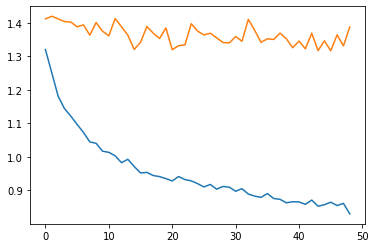

In [17]:
bciiv2a_EEGNet, bciiv2a_data = bciiv2a(EEGNet, epochs=49, Reptile=False)

In [18]:
results_bciiv2a_EEGNet = evaluate(bciiv2a_EEGNet, bciiv2a_data)

0-shot accuracy: 	mean: 58.854167%	std: 9.589559%


100%|██████████| 73/73 [05:06<00:00,  4.20s/it]


1-shot accuracy: 	mean: 58.258929%	std: 13.051834%	after 73 updates


100%|██████████| 73/73 [04:32<00:00,  3.73s/it]


2-shot accuracy: 	mean: 63.541667%	std: 13.700986%	after 67 updates


100%|██████████| 73/73 [03:53<00:00,  3.20s/it]


3-shot accuracy: 	mean: 63.437500%	std: 11.052962%	after 113 updates


100%|██████████| 73/73 [03:37<00:00,  2.99s/it]


4-shot accuracy: 	mean: 65.277778%	std: 14.316339%	after 103 updates


100%|██████████| 73/73 [03:26<00:00,  2.83s/it]


5-shot accuracy: 	mean: 68.750000%	std: 12.103073%	after 135 updates


100%|██████████| 73/73 [03:28<00:00,  2.86s/it]


6-shot accuracy: 	mean: 66.964286%	std: 12.814911%	after 71 updates


100%|██████████| 73/73 [03:38<00:00,  3.00s/it]


7-shot accuracy: 	mean: 69.711538%	std: 11.458053%	after 97 updates


100%|██████████| 73/73 [03:45<00:00,  3.09s/it]


8-shot accuracy: 	mean: 69.791667%	std: 11.073069%	after 147 updates


100%|██████████| 73/73 [03:50<00:00,  3.16s/it]


9-shot accuracy: 	mean: 66.477273%	std: 9.709095%	after 145 updates


100%|██████████| 73/73 [03:50<00:00,  3.15s/it]

10-shot accuracy: 	mean: 68.125000%	std: 8.592329%	after 37 updates


In [19]:
bciiv2a_EEGNet_Reptile, bciiv2a_data = bciiv2a(EEGNet, iterations=30000, Reptile=True)

episode: 0 	finetune acc:20.000000 		test acc:20.833333
episode: 50 	finetune acc:42.500000 		test acc:52.083333
episode: 100 	finetune acc:41.250000 		test acc:45.833333
episode: 150 	finetune acc:46.250000 		test acc:60.416667
episode: 200 	finetune acc:41.250000 		test acc:50.000000
episode: 250 	finetune acc:43.750000 		test acc:66.666667
episode: 300 	finetune acc:51.250000 		test acc:52.083333
episode: 350 	finetune acc:56.250000 		test acc:56.250000
episode: 400 	finetune acc:46.250000 		test acc:56.250000
episode: 450 	finetune acc:48.750000 		test acc:50.000000
episode: 500 	finetune acc:50.000000 		test acc:47.916667
episode: 550 	finetune acc:57.500000 		test acc:58.333333
episode: 600 	finetune acc:50.000000 		test acc:62.500000
episode: 650 	finetune acc:51.250000 		test acc:54.166667
episode: 700 	finetune acc:57.500000 		test acc:50.000000
episode: 750 	finetune acc:61.250000 		test acc:58.333333
episode: 800 	finetune acc:62.500000 		test acc:60.416667
episode: 850 	fin

In [20]:
results_bciiv2a_EEGNet_Reptile = evaluate(bciiv2a_EEGNet_Reptile, bciiv2a_data)

0-shot accuracy: 	mean: 63.020833%	std: 12.704491%


100%|██████████| 73/73 [05:20<00:00,  4.39s/it]


1-shot accuracy: 	mean: 66.071429%	std: 8.423197%	after 91 updates


100%|██████████| 73/73 [04:45<00:00,  3.91s/it]


2-shot accuracy: 	mean: 65.625000%	std: 8.462540%	after 125 updates


100%|██████████| 73/73 [04:07<00:00,  3.39s/it]


3-shot accuracy: 	mean: 66.875000%	std: 12.358575%	after 5 updates


100%|██████████| 73/73 [03:50<00:00,  3.15s/it]


4-shot accuracy: 	mean: 66.666667%	std: 15.023130%	after 109 updates


100%|██████████| 73/73 [03:33<00:00,  2.92s/it]


5-shot accuracy: 	mean: 68.359375%	std: 8.405248%	after 5 updates


100%|██████████| 73/73 [03:31<00:00,  2.89s/it]


6-shot accuracy: 	mean: 68.750000%	std: 9.149063%	after 21 updates


100%|██████████| 73/73 [03:40<00:00,  3.03s/it]


7-shot accuracy: 	mean: 69.711538%	std: 12.219486%	after 71 updates


100%|██████████| 73/73 [03:48<00:00,  3.12s/it]


8-shot accuracy: 	mean: 71.354167%	std: 11.540896%	after 131 updates


100%|██████████| 73/73 [03:52<00:00,  3.18s/it]


9-shot accuracy: 	mean: 69.886364%	std: 5.849790%	after 79 updates


100%|██████████| 73/73 [03:50<00:00,  3.16s/it]

10-shot accuracy: 	mean: 73.125000%	std: 12.199513%	after 53 updates


In [21]:
torch.save(bciiv2a_EEGNet_Reptile.net.state_dict(), 'bciiv2a_EEGNet_Reptile_checkpoint2.pth')